In [157]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
import glob
import datetime as dt
from sklearn.metrics import r2_score
from numba import jit

# Prepare data

In [158]:
# Params
if 'Saketh' in os.getcwd():
    hfzoo_data_folder = '../../../../GitHub/HFZoo/data'
    hfzoo_return_folder = f"{hfzoo_data_folder}/proc/factor_returns_with_jumpind"
else:
    hfzoo_data_folder = '/Users/au515538/Desktop/HFML/data'
    hfzoo_return_folder = f"{hfzoo_data_folder}/proc/_temp"

## Models

In [204]:
%%time
data_set = 'No_overnight'

## Params
drop_overnight = True

# Models
if data_set == 'Rolling' or data_set == 'Rolling_1460':
    st_model = ['Benchmark','LR','LR_PCA_select', 'LR_Lasso_select', 'Lasso','Lasso_PCA_select','Enet','Enet_PCA_select', 'NN', 'NN_PCA','NN_Lasso']
    
elif data_set == 'Rolling_cts' or data_set == 'Rolling_jump':
    st_model = ['Benchmark','LR','LR_PCA_select', 'LR_Lasso_select', 'Lasso']

elif data_set == 'No_overnight':
    st_model = ['Benchmark','LR','LR_PCA_select', 'LR_Lasso_select', 'Lasso','Lasso_PCA_select','Enet', 'NN', 'NN_PCA','NN_Lasso']


    
else:
    st_model = ['Benchmark','LR','LR_PCA_select', 'LR_Lasso_select', 'Lasso','Lasso_PCA_select','Enet','Enet_PCA_select']

    
# Load model results
for i in range(0,len(st_model)):
    if i == 0:
        forecast_oss_df = pd.read_parquet('../../Results/' + data_set + '/Results/' + st_model[i] + '_oss.parquet')
        forecast_oss_df = forecast_oss_df.rename(columns={'0': 'oss_' + st_model[i]})
    else:
        results = pd.read_parquet('../../Results/' + data_set + '/Results/' + st_model[i] + '_oss.parquet')
        forecast_oss_df['oss_' + st_model[i]] = results['0']

        
for i in range(0,len(st_model)):
    if i == 0:
        forecast_ins_df = pd.read_parquet('../../Results/' + data_set + '/Results/' + st_model[i] + '_insample.parquet')
        forecast_ins_df = forecast_ins_df.rename(columns={'ff__mkt': 'ins_' + st_model[i]})
    else:
        results = pd.read_parquet('../../Results/' + data_set + '/Results/' + st_model[i] + '_insample.parquet')
        forecast_ins_df['ins_' + st_model[i]] = results['ff__mkt']

CPU times: user 167 ms, sys: 55.6 ms, total: 222 ms
Wall time: 222 ms


### Adjust sample period for OOS predictions

In [205]:
forecast_oss_df = forecast_oss_df.loc['2004':]

## Returns

In [206]:
fret_df = pd.concat(
    [
        pd.read_parquet(x, columns=["ff__mkt"])
       for x in glob.glob(f"{hfzoo_return_folder}/*_all.parquet")
        
    ]
)

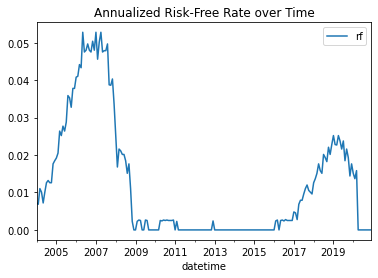

In [207]:
## Risk Free Rate
# Read in data
ff_daily_df = pd.read_csv(
    "../../data/ff/F-F_Research_Data_5+1_daily.csv", skiprows=3, engine="python"
)

# Clean up
ff_daily_df.columns = ["date", "mktrf", "smb", "hml", "rmw", "cma", "rf", "umd"]
ff_daily_df["date"] = pd.to_datetime(ff_daily_df["date"].astype(str))

# Select data for risk-free rate
rf_df = ff_daily_df[["date", "rf"]].query('date > "1995-12-31"').copy()
rf_df["rf"] = np.log(1 + rf_df["rf"] / 100)
rf_df['date'] = pd.to_datetime(rf_df['date'])
rf_df = rf_df.set_index("date")

# Resample the risk free at high-freq
hrf_df = forecast_oss_df[[]].assign(date = forecast_oss_df.index.date).reset_index().set_index('date').join(rf_df).reset_index()
hrf_df['rf'] = hrf_df['rf'] / hrf_df.groupby('date')['rf'].transform('count')
hrf_df = hrf_df.set_index('datetime')

# View results
hrf_df.groupby(pd.Grouper(freq = '1m')).sum().pipe(lambda x: x*12).plot()
plt.title('Annualized Risk-Free Rate over Time');

## Spreads

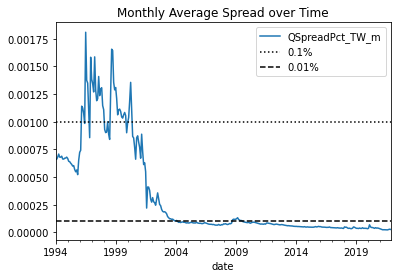

In [208]:
## Spreads
spread_df = pd.read_csv('../../data/taq/spy_spread.csv')
spread_df['date'] = pd.to_datetime(spread_df['date'], format = '%Y%m%d')
spread_df = spread_df.set_index('date').resample('15min').first().ffill()
spread_df.groupby(pd.Grouper(freq = '1m')).mean().plot(y = 'QSpreadPct_TW_m')
plt.axhline(0.001, color = 'k', ls = ':', label = "0.1%")
plt.axhline(0.0001, color = 'k', ls = '--', label = "0.01%")
plt.legend()
plt.title('Monthly Average Spread over Time');

# Analyze

## R-Squared

In [209]:
forecast_oss_df["truth"] = fret_df["ff__mkt"]
forecast_ins_df["truth"] = fret_df["ff__mkt"]

#if over_night == 1:
#    rvol = pd.read_parquet('rvol_no_ovr.parquet')
# else:
#     rvol        = pd.read_parquet('rvol.parquet')

# forecast_oss_df["rvol"] = rvol["ff__mkt_rv_hat_intradaily"]
# forecast_ins_df["rvol"] = rvol["ff__mkt_rv_hat_intradaily"]



def compute_rsquared(truth, pred):
    return 1 - np.sum(np.square(truth-pred))/np.sum(np.square(truth))


forecast_oss_df_positive = forecast_oss_df[forecast_oss_df>0]
forecast_oss_df_positive = forecast_oss_df_positive.fillna(0)

metrics_df_oss = pd.DataFrame([], index = [col for col in forecast_oss_df.columns if 'oss' in col])
metrics_df_ins = pd.DataFrame([], index = [col for col in forecast_ins_df.columns if 'oss' in col])


for col in forecast_oss_df.columns:
    if 'oss' in col:
        metrics_df_oss.loc[col, 'R2_oss'] = compute_rsquared(forecast_oss_df['truth'], forecast_oss_df[col])


for col in forecast_ins_df.columns:        
    if 'ins' in col:
        metrics_df_ins.loc[col, 'R2_ins'] = compute_rsquared(forecast_ins_df['truth'], forecast_ins_df[col])
        

print('OSS:')
print(metrics_df_oss)

print('insample:')
print(metrics_df_ins)

OSS:
                        R2_oss
oss_Benchmark         0.000352
oss_LR               -0.031421
oss_LR_PCA_select     0.000360
oss_LR_Lasso_select  -0.000055
oss_Lasso             0.000687
oss_Lasso_PCA_select  0.000433
oss_Enet              0.000680
oss_NN               -0.001172
oss_NN_PCA           -0.000105
oss_NN_Lasso         -0.000010
insample:
                        R2_ins
ins_Benchmark         0.000876
ins_LR                0.018149
ins_LR_PCA_select     0.001824
ins_LR_Lasso_select  -0.000080
ins_Lasso             0.002023
ins_Lasso_PCA_select  0.001454
ins_Enet              0.002023
ins_NN                0.019297
ins_NN_PCA            0.000100
ins_NN_Lasso         -0.002551


In [215]:
forecast_oss_df

,oss_Benchmark,oss_LR,oss_LR_PCA_select,oss_LR_Lasso_select,oss_Lasso,oss_Lasso_PCA_select,oss_Enet,oss_NN,oss_NN_PCA,oss_NN_Lasso,truth
datetime,,,,,,,,,,,
2004-01-02 09:45:00,-0.000029,-0.000115,0.000060,0.000082,0.000034,0.000021,0.000033,-0.000026,-0.000053,5.616687e-05,0.001607
2004-01-02 10:00:00,0.000093,-0.000723,-0.000423,0.000006,-0.000010,-0.000161,-0.000010,-0.000191,-0.000072,6.973825e-06,-0.000880
2004-01-02 10:15:00,-0.000020,-0.000353,-0.000145,0.000046,0.000002,-0.000047,0.000002,-0.000103,-0.000045,1.704595e-05,0.002169
2004-01-02 10:30:00,0.000117,-0.000191,-0.000198,-0.000046,-0.000042,-0.000047,-0.000042,-0.000040,0.000018,-2.077842e-05,-0.000205
2004-01-02 10:45:00,0.000014,-0.000271,-0.000128,0.000012,-0.000005,-0.000038,-0.000005,-0.000040,-0.000029,6.986432e-06,-0.000047
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 15:00:00,0.000012,0.000042,0.000012,0.000018,0.000011,0.000008,0.000012,0.000024,0.000018,3.147463e-07,-0.000660
2020-12-31 15:15:00,-0.000008,0.000228,-0.000010,0.000018,0.000005,-0.000012,0.000004,0.000017,0.000018,1.839050e-06,0.001633
2020-12-31 15:30:00,0.000015,-0.000059,0.000029,0.000018,0.000022,0.000021,0.000022,0.000025,0.000018,1.969232e-06,-0.000421


In [216]:
x = forecast_oss_df.groupby(pd.Grouper(freq ='1y')).sum() 
compute_rsquared(x['truth'], x['oss_Lasso'])

-0.6692705108661907

In [182]:
select = ['Select']
Model  = ['Model']
for x in metrics_df_ins.index:  
    try: 
        Model.append(str(x.split('_')[1]))
        
        try: 
            select.append(str(x.split('_')[2]))
        except:
            select.append('-')
        
    except:
        Model.append('-')
        
f = open('../../code/results_analysis/paper/tables/R2_output_' + data_set + '.txt','w')
f.write("\\begin{table}[H] \n 	\\setlength{\\tabcolsep}{0.5cm} \n  \\begin{center} \n") 
f.write("\\caption{R2} \n \\smallskip")
f.write("\\begin{tabular}{" + "l" +"".join(["r"] * 4) + "}\n")
f.write("\\hline \\hline \n")  
f.write("Model" " & " "Selection"  " & " "In-sample"  " & " "Out-of-sample"  "\\\\\n")
f.write("\\hline \n")   
for i in range(len(metrics_df_ins.values)):
    f.write(Model[i + 1] + " & " + " " + select[i + 1] + " & "  + str('{:.3f}'.format(100*float(metrics_df_ins.values[i]))) + " & "  + str('{:.3f}'.format(100*float(metrics_df_oss.values[i]))) + " & " "\\\\\n")
            
f.write("\\hline \\hline \n")   
f.write("\\end{tabular} \n")
f.write("\\smallskip \n \\begin{scriptsize} \n")
f.write("\\parbox{\\textwidth}{\\emph{Note. } } \n")
f.write("\\end{scriptsize} \n \\end{center} \n \\end{table}")
f.close()

## Trading strategies

### Prep

In [183]:
# Define strategies and models
strategies_list = [
    "Market",
    "Sign",
    "Positive",
    "Standard Error",
    "Tanh",
    "Alternative Strategy 0.9",
    "Alternative Strategy 0.5",
    "Spread-aware",
]
model_name_list = st_model.copy()

# True returns
returns_actual = forecast_oss_df["truth"]

## Useful variables
# Constants
n_years = (forecast_oss_df.index.max() - forecast_oss_df.index.min()).days / 365
n_obs_per_year = forecast_oss_df.groupby(pd.Grouper(freq="1y"))["truth"].count().mean()
n_obs = len(returns_actual)

# Risk-free rate
R_f = hrf_df['rf']

### Strategies

In [184]:
# Inputs are a dictionary with info about the model
# Includes model predictions


def get_weights_passive(model_info_dict):
    """Invest everything in the market."""

    # Just set weights to 1
    # Reuse prediction series to figure out index
    model_pred = model_info_dict["model_pred"]
    weights = model_pred * 0 + 1

    return weights


def get_weights_sign(model_info_dict):
    """Invest based on sign of forecast."""

    # Simply the sign of the predictions
    model_pred = model_info_dict["model_pred"]
    weights = np.sign(model_pred)

    return weights


def get_weights_sign_positive(model_info_dict):
    """Invest based on sign but no shorting"""

    # Sign of the predictions with negative
    # weights replaced with 0
    weights = get_weights_sign(model_info_dict)
    weights[weights < 0] = 0

    return weights


def get_weights_stderr(model_info_dict, cutoff):
    """Invest based on some standard error cutoff.
    Weights are non-negative, cutoff is a arg
    """

    # Invest whenever prediction exceeds cutoff
    model_pred = model_info_dict["model_pred"]
    model_pred_std = model_info_dict["model_pred_std"]
    weights = model_pred > cutoff * model_pred_std

    return weights


def get_weights_tanh(model_info_dict):
    """Invest with weights based on tanh of the
    z-score of the prediction; force positive weights
    """

    # Invest whenever prediction exceeds cutoff
    model_pred = model_info_dict["model_pred"]
    model_pred_std = model_info_dict["model_pred_std"]
    # y = (intradaily sharpe) * (annualization factor)
    y = model_pred / model_pred_std * np.sqrt(252*27)
    # z = standardized y
    z = y / np.std(y)
    # tanh of z
    weights = np.tanh(z)
    weights[model_pred < 0] = 0

    return weights


@jit
def compute_ms_weights_fast(trade_ind, cutoff):
    """Trade indicator could either be tanh(zscores)
    or just the sign of the model. The former
    is meant for the "0.5" and "0.9" style strategies,
    while the latter can be used to implement the
    "MS Positive" strategy by setting the cutoff to 0
    """

    n = np.shape(trade_ind)[0]
    weights = np.zeros(n)
    count_post = 0
    in_trade = 0

    for i in range(n):
        if trade_ind[i] > cutoff:
            in_trade = 1

        if trade_ind[i] < 0:
            in_trade = 0

        if in_trade == 1:
            # While we are holding,
            # the weight is set to one
            weights[i] = 1

    return weights


def get_weights_ms_strat(model_info_dict, cutoff):
    """Mathias's top secret trading strategy"""

    # Tanh of z-scores of predictions
    model_pred = model_info_dict["model_pred"]
    # model_pred_std = model_info_dict["model_pred_std"]
    model_pred_z_tanh = np.tanh(model_pred / np.std(model_pred))

    # Get weights using fast numba function
    X_tanh = model_pred_z_tanh.values
    weights = compute_ms_weights_fast(X_tanh, cutoff)
    weights = pd.Series(weights, index=model_pred.index)

    return weights

In [185]:
## Spread cognizant trading


@jit
def compute_spread_responsive_weights(prediction, riskfree, spread):
    """Return prediction comes from model. The cutoff is defined
    by the spread.
    """

    n = np.shape(prediction)[0]

    # Start with money in the market
    w = np.ones(n)

    for i in range(1, n):

        # Check if we should enter the market
        # will lose money from spread but gain the initial return
        if w[i - 1] == 0:
            if (prediction[i] - riskfree[i] - spread[i]) > 0:
                w[i] = 1
            else:
                w[i] = 0

        if w[i - 1] == 1:
            if (prediction[i] - riskfree[i] - spread[i]) < 0:
                w[i] = 0
            else:
                w[i] = 1

    return w


def get_weights_spread_strat(model_info_dict):
    """Spread-aware trading strategy"""

    # Tanh of z-scores of predictions
    model_pred = model_info_dict["model_pred"]
    spread = model_info_dict["spread"]
    riskfree = model_info_dict["riskfree"]

    # Get weights using fast numba function
    weights = compute_spread_responsive_weights(model_pred.values, riskfree.values, spread.values)
    weights = pd.Series(weights, index=model_pred.index)

    return weights

### Process

In [186]:
# %%time

# Output
oss_results_list = []
oss_returns_list = []
oss_weights_list = []
oss_trading_list = []

# Drop overnight?
if drop_overnight:
    market_returns = returns_actual.loc[returns_actual.index.time != dt.time(9, 30)]
    riskfree_returns = R_f.loc[returns_actual.index.time != dt.time(9, 30)]
else:
    market_returns = returns_actual
    riskfree_returns = R_f.loc[returns_actual.index]

# Main loop
for model_idx, model_col_name in enumerate(forecast_oss_df.columns):

    if "oss" not in model_col_name:
        continue
    else:
        print(f"Processing: {model_col_name}")

    # Storing results for each model
    oss_results_model = pd.DataFrame([], index=strategies_list)

    for strategy_idx, strategy_name in enumerate(strategies_list):

        # Basic info
        model_name = model_name_list[model_idx]

        # Model predictions
        model_pred = forecast_oss_df[model_col_name]
        # model_pred_std = np.std(model_pred)
        model_pred_std = (
            pd.read_parquet("../../Results/RV/RV_HAR_oss.parquet")
            .pipe(np.sqrt)
            .iloc[:, 0]
            .loc[model_pred.index]
        )

        # Put into dictionary
        model_info_dict = {}
        model_info_dict["model_pred"] = model_pred
        model_info_dict["model_pred_std"] = model_pred_std
        model_info_dict["spread"] = spread_df["QSpreadPct_TW_m"].loc[model_pred.index]
        model_info_dict["riskfree"] = riskfree_returns

        # Get trading strategy results
        if strategy_name == "Market":
            weights = get_weights_passive(model_info_dict)
        elif strategy_name == "Sign":
            weights = get_weights_sign(model_info_dict)
        elif strategy_name == "Positive":
            weights = get_weights_sign_positive(model_info_dict)
        elif strategy_name == "Standard Error":
            weights = get_weights_stderr(model_info_dict, 1)  #################
        elif strategy_name == "Tanh":
            weights = get_weights_tanh(model_info_dict)
        elif strategy_name == "Alternative Strategy 0.5":
            weights = get_weights_ms_strat(model_info_dict, 0.5)
        elif strategy_name == "Alternative Strategy 0.9":
            weights = get_weights_ms_strat(model_info_dict, 0.9)
        elif strategy_name == "Spread-aware":
            weights = get_weights_spread_strat(model_info_dict)
        else:
            raise Exception("Unknown trading strategy: ", strategy_name)

        # Convert to float
        weights = weights.astype(float)
        
        # Drop during high spread years?
        weights = weights

        # Drop overnight?
        if drop_overnight:
            weights = weights.loc[weights.index.time != dt.time(9, 30)]
            # If drop overnight, market returns and riskfree returns will also differ
            # these were adjusted before the start of the loop

        # Strategy statistics
        portfolio_returns = weights * market_returns + (1 - weights) * (riskfree_returns)
        portfolio_turnover = weights.diff(1).fillna(0).abs()

        # Radj = R - |w_diff|*tau
        portfolio_returns_adj = portfolio_returns - portfolio_turnover.to_frame("turnover").join(
            spread_df[["QSpreadPct_TW_m"]]/2
        ).prod(axis=1)

        # Averages
        portfolio_average_return = portfolio_returns.sum() / n_years
        portfolio_average_return_adj = portfolio_returns_adj.sum() / n_years
        portfolio_average_excess_return = (portfolio_returns - R_f).sum() / n_years
        portfolio_average_excess_return_adj = (portfolio_returns_adj - R_f).sum() / n_years
        portfolio_average_turnover = portfolio_turnover.sum() / n_years
        portfolio_average_vol = np.sqrt(np.square(portfolio_returns).sum() / n_years)
        portfolio_sharpe = portfolio_average_excess_return / portfolio_average_vol
        portfolio_sharpe_adj = portfolio_average_excess_return_adj / portfolio_average_vol

        # Save results to dataframe
        oss_results_model.loc[strategy_name, "Return"] = round(portfolio_average_return, 2)
        oss_results_model.loc[strategy_name, "ReturnAdj"] = round(portfolio_average_return_adj, 2)
        oss_results_model.loc[strategy_name, "Trades"] = round(portfolio_average_turnover, 1)
        oss_results_model.loc[strategy_name, "Sharpe"] = round(portfolio_sharpe, 2)
        oss_results_model.loc[strategy_name, "SharpeAdj"] = round(portfolio_sharpe_adj, 2)
        oss_results_model.loc[strategy_name, "rvol"] = round(portfolio_average_vol, 2)
        oss_results_model.loc[strategy_name, "Name (col)"] = model_col_name
        oss_results_model.loc[strategy_name, "Name"] = model_name
        oss_returns_model = portfolio_returns
        oss_returns_model.name = (model_name, strategy_name)
        oss_weights_model = weights
        oss_weights_model.name = (model_name, strategy_name)

        # Append to running list of returns
        oss_returns_list.append(oss_returns_model)
        oss_weights_list.append(oss_weights_model)

    # Append to running list of results
    oss_results_list.append(oss_results_model)

Processing: oss_Benchmark
Processing: oss_LR
Processing: oss_LR_PCA_select
Processing: oss_LR_Lasso_select
Processing: oss_Lasso
Processing: oss_Lasso_PCA_select
Processing: oss_Enet
Processing: oss_Enet_PCA_select
Processing: oss_NN
Processing: oss_NN_PCA
Processing: oss_NN_Lasso


In [187]:
oss_results_model

,Return,ReturnAdj,Trades,Sharpe,SharpeAdj,rvol,Name (col),Name
Market,0.10,0.10,0.0,0.46,0.46,0.18,oss_NN_Lasso,NN_Lasso
Sign,0.09,0.02,1971.0,0.45,0.05,0.18,oss_NN_Lasso,NN_Lasso
Positive,0.10,0.06,985.5,0.50,0.28,0.17,oss_NN_Lasso,NN_Lasso
Standard Error,0.01,0.01,0.0,0.00,0.00,0.00,oss_NN_Lasso,NN_Lasso
Tanh,0.07,0.03,1127.3,0.65,0.21,0.10,oss_NN_Lasso,NN_Lasso
Alternative Strategy 0.9,0.06,0.05,270.3,0.33,0.25,0.14,oss_NN_Lasso,NN_Lasso
Alternative Strategy 0.5,0.05,0.03,520.3,0.24,0.12,0.16,oss_NN_Lasso,NN_Lasso
Spread-aware,0.05,0.02,700.0,0.47,0.11,0.07,oss_NN_Lasso,NN_Lasso


In [188]:
for metric in ['Return', 'ReturnAdj', 'Trades', 'Sharpe', 'SharpeAdj', 'rvol']:
    pivot_df = pd.concat(oss_results_list)[[metric, 'Name']].reset_index().pivot(index = 'index', columns = 'Name', values = metric)
    pivot_df = pivot_df[st_model]
    pivot_df=pivot_df.iloc[[2,3,5,4,6,7,0,1]]

    select = ['Select']
    for x in pivot_df.columns:  
        try: 
            select.append(str(x.split('_')[1]))
        except:
            select.append('-')

    f = open('../../code/results_analysis/paper/tables/' + metric + '_output_' + data_set + '.txt','w')
    f.write("\\begin{table}[H] \n 	\\setlength{\\tabcolsep}{0.1cm} \n  \\begin{center} \n") 
    f.write("\\caption{" + metric + "} \n \\smallskip")
    f.write("\\begin{tabular}{" + "l" +"".join(["r"] * len(pivot_df.columns)) + "}\n")
    f.write("\\hline \\hline \n")  
    f.write("Strategy" " & " + " & ".join([str(x.split('_',1)[0]) for x in pivot_df.columns]) + " \\\\\n")
    f.write(" & ".join(select) + " \\\\\n")
    f.write("\\hline \n")   
    if metric =='Trades':
        for i, row in pivot_df.iterrows():
            f.write(i+ " & " + " & ".join([str('{:.0f}'.format(x)) for x in row.values]) + " \\\\\n")
    else:
        for i, row in pivot_df.iterrows():
            f.write(i+ " & " + " & ".join([str('{:.2f}'.format(x)) for x in row.values]) + " \\\\\n")
    f.write("\\hline \\hline \n")   
    f.write("\\end{tabular} \n")
    f.write("\\smallskip \n \\begin{scriptsize} \n")
    f.write("\\parbox{\\textwidth}{\\emph{Note. } } \n")
    f.write("\\end{scriptsize} \n \\end{center} \n \\end{table}")
    f.close()

In [189]:
data_set

'Rolling'

In [190]:
# Merge results
oss_results_all_df = pd.concat(oss_results_list)
oss_returns_all_df = pd.concat(oss_returns_list, axis = 1)
oss_weights_all_df = pd.concat(oss_weights_list, axis = 1)

<AxesSubplot:xlabel='datetime'>

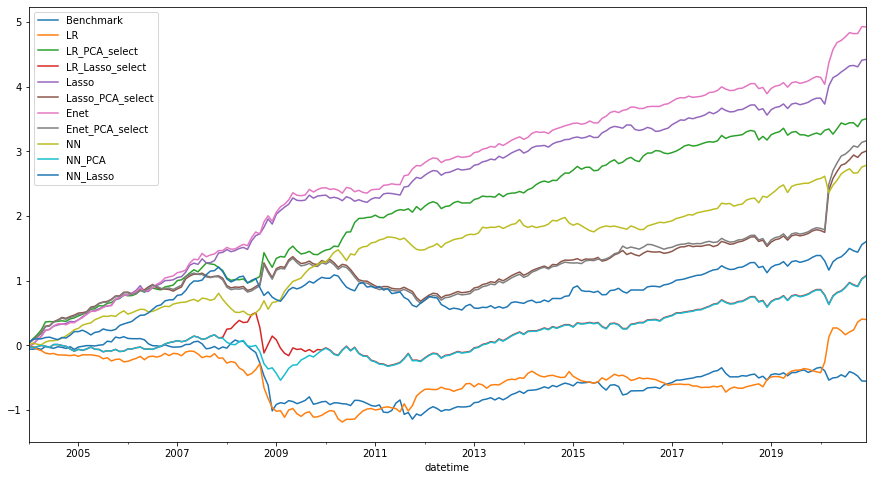

In [191]:
fig,ax=plt.subplots(figsize=(15,8))
oss_returns_all_df.swaplevel(0, 1, axis=1)['Sign'].groupby(pd.Grouper(freq='1m')).sum().cumsum().plot(ax=ax)

In [77]:
# oss_trading_all_df['Lasso_PCA_select'].plot()

### Save

In [153]:
oss_returns_all_df

Benchmark                                               \
                       Market      Sign  Positive Standard Error      Tanh   
datetime                                                                     
2010-01-04 09:30:00  0.009204 -0.009204  0.000000            0.0  0.000000   
2010-01-04 09:45:00  0.002273 -0.002273  0.000000            0.0  0.000000   
2010-01-04 10:00:00  0.000954  0.000954  0.000954            0.0  0.000189   
2010-01-04 10:15:00  0.000608  0.000608  0.000608            0.0  0.000219   
2010-01-04 10:30:00  0.001722  0.001722  0.001722            0.0  0.000789   
...                       ...       ...       ...            ...       ...   
2020-12-31 15:00:00 -0.000660 -0.000660 -0.000660            0.0 -0.000589   
2020-12-31 15:15:00  0.001633  0.001633  0.001633            0.0  0.000902   
2020-12-31 15:30:00 -0.000421 -0.000421 -0.000421            0.0 -0.000347   
2020-12-31 15:45:00  0.000072  0.000072  0.000072            0.0  0.000035   
2020-12-31 16:00:00  0.001611  0.001611  0.001611            0.0  0.001247   

                                                                       \
                    Alternative Strategy 0.9 Alternative Strategy 0.5   
datetime                                                                
2010-01-04 09:30:00                 0.000000                 0.000000   
2010-01-04 09:45:00                 0.000000                 0.000000   
2010-01-04 10:00:00                 0.000000                 0.000000   
2010-01-04 10:15:00                 0.000000                 0.000000   
2010-01-04 10:30:00                 0.000000                 0.000000   
...                                      ...                      ...   
2020-12-31 15:00:00                -0.000660                -0.000660   
2020-12-31 15:15:00                 0.001633                 0.001633   
2020-12-31 15:30:00                -0.000421                -0.000421   
2020-12-31 15:45:00                 0.000072                 0.000072   
2020-12-31 16:00:00                 0.001611                 0.001611   

                                        LR            ...  \
                    Spread-aware    Market      Sign  ...   
datetime                                              ...   
2010-01-04 09:30:00     0.009204  0.009204 -0.009204  ...   
2010-01-04 09:45:00     0.000000  0.002273 -0.002273  ...   
2010-01-04 10:00:00     0.000000  0.000954 -0.000954  ...   
2010-01-04 10:15:00     0.000000  0.000608 -0.000608  ...   
2010-01-04 10:30:00     0.000000  0.001722 -0.001722  ...   
...                          ...       ...       ...  ...   
2020-12-31 15:00:00    -0.000660 -0.000660 -0.000660  ...   
2020-12-31 15:15:00     0.000000  0.001633  0.001633  ...   
2020-12-31 15:30:00    -0.000421 -0.000421 -0.000421  ...   
2020-12-31 15:45:00     0.000000  0.000072  0.000072  ...   
2020-12-31 16:00:00     0.000000  0.001611  0.001611  ...   

                                      NN_PCA               NN_Lasso            \
                    Alternative Strategy 0.5 Spread-aware    Market      Sign   
datetime                                                                        
2010-01-04 09:30:00                 0.000000     0.009204  0.009204 -0.009204   
2010-01-04 09:45:00                 0.000000     0.000000  0.002273  0.002273   
2010-01-04 10:00:00                 0.000000     0.000000  0.000954  0.000954   
2010-01-04 10:15:00                 0.000000     0.000000  0.000608  0.000608   
2010-01-04 10:30:00                 0.000000     0.000000  0.001722  0.001722   
...                                      ...          ...       ...       ...   
2020-12-31 15:00:00                -0.000660    -0.000660 -0.000660 -0.000660   
2020-12-31 15:15:00                 0.001633     0.001633  0.001633  0.001633   
2020-12-31 15:30:00                -0.000421    -0.000421 -0.000421 -0.000421   
2020-12-31 15:45:00                 0.000072     0.000072  0.000072  0.000072

In [151]:
oss_results_all_df.to_parquet('../../Results/trading_results/results.parquet')
oss_returns_all_df.to_parquet('../../Results/trading_results/returns.parquet')
oss_weights_all_df.to_parquet('../../Results/trading_results/weights.parquet')

ValueError: parquet must have string column names

## Sharpe

### No Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

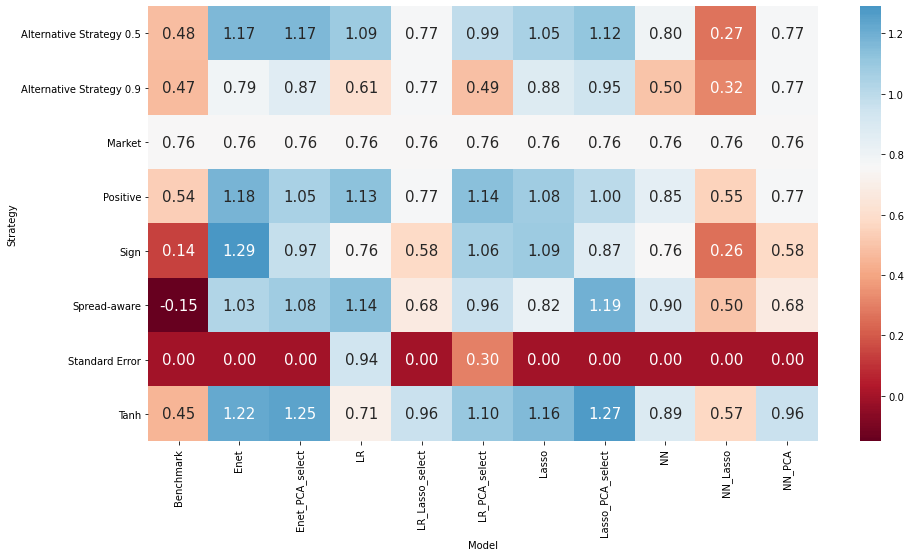

In [117]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="Sharpe")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df,
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

### Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

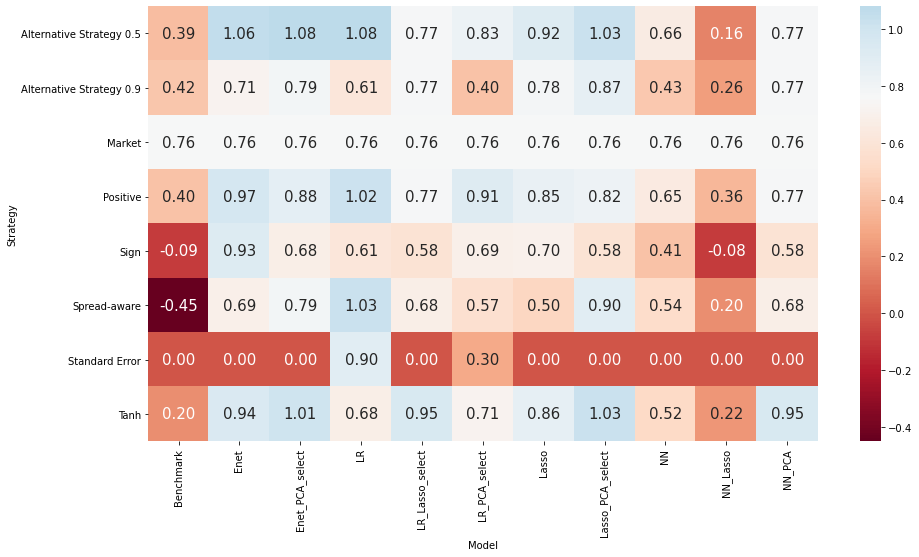

In [118]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="SharpeAdj")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df,
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

## Returns

### No Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

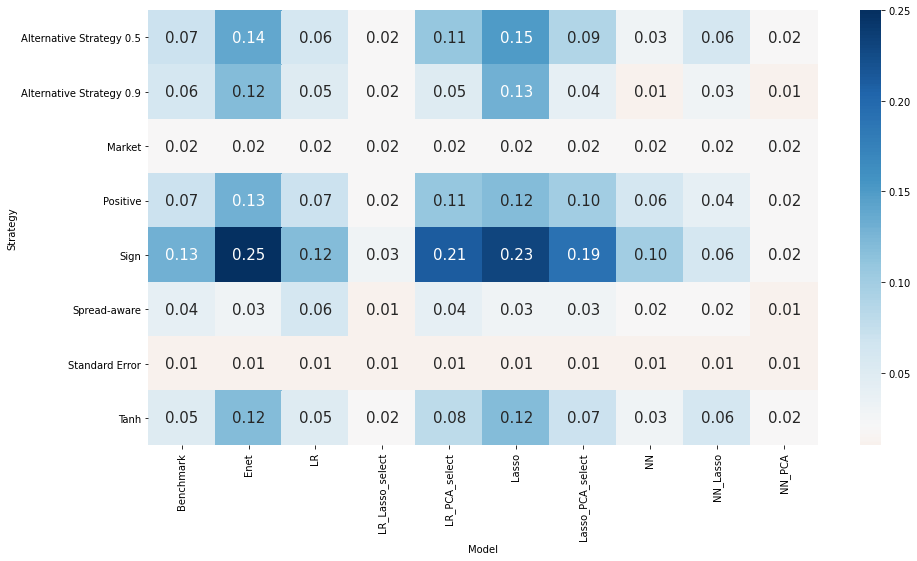

In [175]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="Return")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df,
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

### Transaction Costs

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

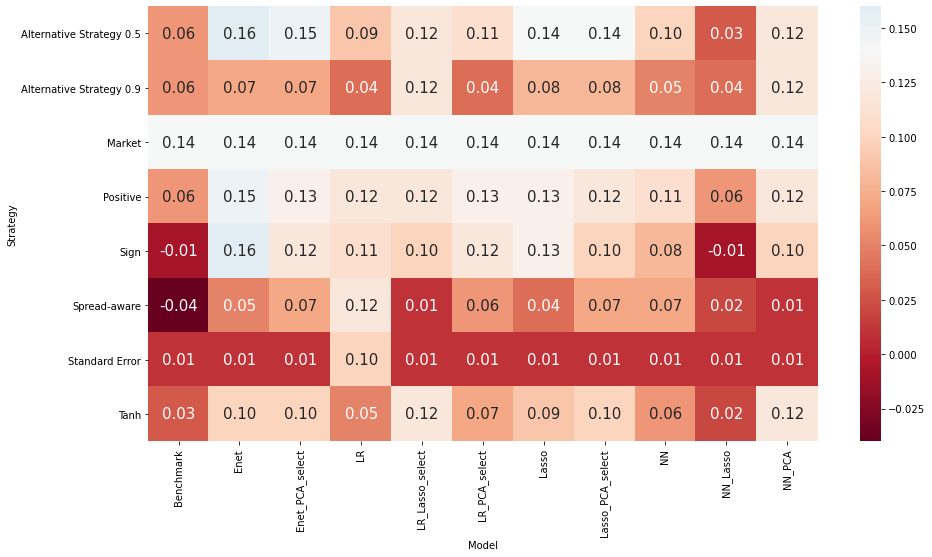

In [120]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="ReturnAdj")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df,
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".2f",
    annot=True,
    annot_kws={"fontsize": 15},
)

## Turnover

<AxesSubplot:xlabel='Model', ylabel='Strategy'>

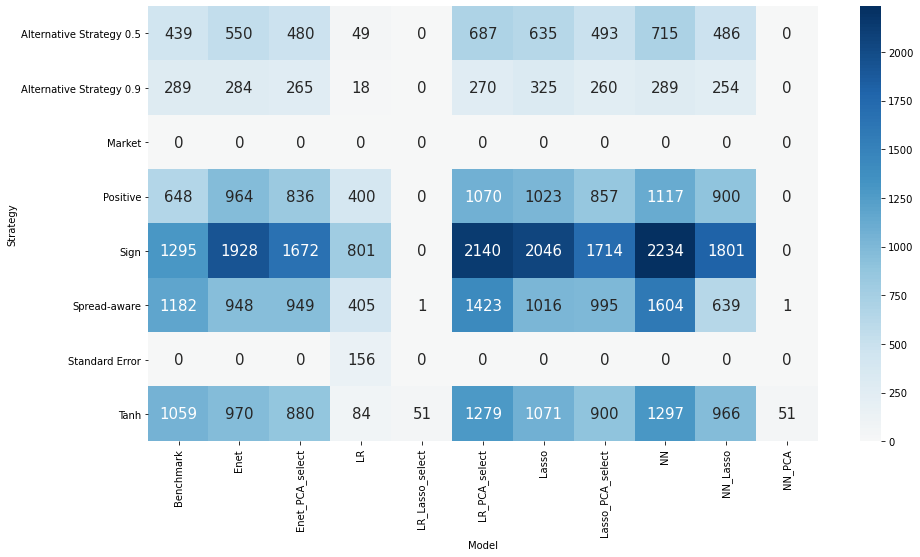

In [83]:
## Set up data
# Pivot to have strategies in the index and models in the columns
oss_results_pivot_df = (
    oss_results_all_df.reset_index()
    .rename(columns={"Name": "Model", "index": "Strategy"})
    .pivot(index="Strategy", columns="Model", values="Trades")
)

## Plot
fig, ax = plt.subplots(figsize=(15, 8))

sns.heatmap(
    oss_results_pivot_df,
    center=oss_results_pivot_df.loc["Market", "Benchmark"],
    cmap="RdBu",
    fmt=".0f",
    annot=True,
    annot_kws={"fontsize": 15},
)